<a href="https://colab.research.google.com/github/hyunku/Brain-Machine_Interface_System/blob/main/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##필요 모듈 import
import os
import sys
import pandas as pd
import numpy as np
from scipy import signal
import mne
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
from datetime import datetime
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [ ]:
# define parameters
n_channels = 6 
s_freq = 128  # in Hertz
ch_names = ['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8']
ch_types = ['eeg'] * n_channels
all_ch_names = ch_names + ['Task','STM']
all_ch_types = ch_types + ['misc','misc']
p_detrend = 1 # 0: OFF, 1: On
p_normalization = 1 # 0: do not, 1: [0, 1] scaling, 2: standardization (x-mean)/var
p_n_filenames = 7
p_ica_flag = 1
p_ts_psd_flag = 0
l_freqs = 1
h_freqs = 60

In [ ]:
eeg=pd.read_csv("preprocessed_16days_update.csv").drop(['Unnamed: 0'],axis=1)
eeg

,timestamp,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,...,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma,event
0,2022-07-15 03:53:43.005288,-8.012494e+09,-2.860742e+10,-2.479036e+10,-2.443542e+10,-2.544167e+10,-2.036193e+10,-8.045803e+09,-2.861909e+10,-2.477033e+10,...,-2.442412e+10,-2.541881e+10,-2.032130e+10,-8.067544e+09,-2.864487e+10,-2.476928e+10,-2.442586e+10,-2.542091e+10,-2.032434e+10,-1
1,2022-07-15 03:53:43.520364,-8.008656e+09,-2.861108e+10,-2.479984e+10,-2.444083e+10,-2.544892e+10,-2.037084e+10,-8.058765e+09,-2.863288e+10,-2.478047e+10,...,-2.442936e+10,-2.542329e+10,-2.032819e+10,-8.066993e+09,-2.864560e+10,-2.477257e+10,-2.442784e+10,-2.542202e+10,-2.032739e+10,-1
2,2022-07-15 03:53:44.026203,-8.009610e+09,-2.860686e+10,-2.479559e+10,-2.443557e+10,-2.544080e+10,-2.036521e+10,-8.060531e+09,-2.863573e+10,-2.477809e+10,...,-2.442847e+10,-2.542327e+10,-2.033231e+10,-8.064065e+09,-2.864343e+10,-2.477482e+10,-2.442771e+10,-2.542215e+10,-2.033030e+10,-1
3,2022-07-15 03:53:44.536857,-8.008431e+09,-2.861457e+10,-2.480828e+10,-2.444425e+10,-2.545120e+10,-2.037621e+10,-8.058579e+09,-2.863598e+10,-2.477270e+10,...,-2.442841e+10,-2.542247e+10,-2.033255e+10,-8.062589e+09,-2.864384e+10,-2.477969e+10,-2.442972e+10,-2.542368e+10,-2.033354e+10,-1
4,2022-07-15 03:53:45.046329,-8.006223e+09,-2.860545e+10,-2.480003e+10,-2.443500e+10,-2.543912e+10,-2.036774e+10,-8.056021e+09,-2.863867e+10,-2.476944e+10,...,-2.442860e+10,-2.542211e+10,-2.033425e+10,-8.058559e+09,-2.864100e+10,-2.478084e+10,-2.442910e+10,-2.542292e+10,-2.033568e+10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60610,2022-08-04 03:18:06.169118,3.863451e+09,1.539810e+09,-8.402576e+08,-1.877600e+09,-1.342357e+09,6.375323e+09,3.756707e+09,1.425880e+09,-9.817256e+08,...,-1.902052e+09,-1.361234e+09,6.343078e+09,3.825454e+09,1.501131e+09,-8.768235e+08,-1.899824e+09,-1.358551e+09,6.344399e+09,1
60611,2022-08-04 03:18:06.679120,3.869584e+09,1.545872e+09,-8.312726e+08,-1.873708e+09,-1.338893e+09,6.382324e+09,3.736095e+09,1.428414e+09,-9.846491e+08,...,-1.906994e+09,-1.362909e+09,6.344054e+09,3.819582e+09,1.499297e+09,-8.786797e+08,-1.909474e+09,-1.365035e+09,6.341866e+09,1
60612,2022-08-04 03:18:07.189115,3.872389e+09,1.554156e+09,-8.236501e+08,-1.876288e+09,-1.340820e+09,6.384023e+09,3.722586e+09,1.443878e+09,-9.694828e+08,...,-1.915326e+09,-1.365256e+09,6.341602e+09,3.814696e+09,1.501334e+09,-8.763989e+08,-1.917133e+09,-1.367623e+09,6.340695e+09,1
60613,2022-08-04 03:18:07.699118,3.878095e+09,1.559034e+09,-8.162485e+08,-1.874426e+09,-1.338939e+09,6.389834e+09,3.730039e+09,1.466621e+09,-9.370388e+08,...,-1.923066e+09,-1.368565e+09,6.342943e+09,3.814466e+09,1.505933e+09,-8.697809e+08,-1.920290e+09,-1.366005e+09,6.345358e+09,1


In [ ]:
# data split to X / Y (input / target)
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
train_length = math.ceil(len(eeg) * 0.8) # train data : 80% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg[:train_length]
y_train= train_event[:train_length]
X_test = train_eeg[train_length:]
y_test = train_event[train_length:]

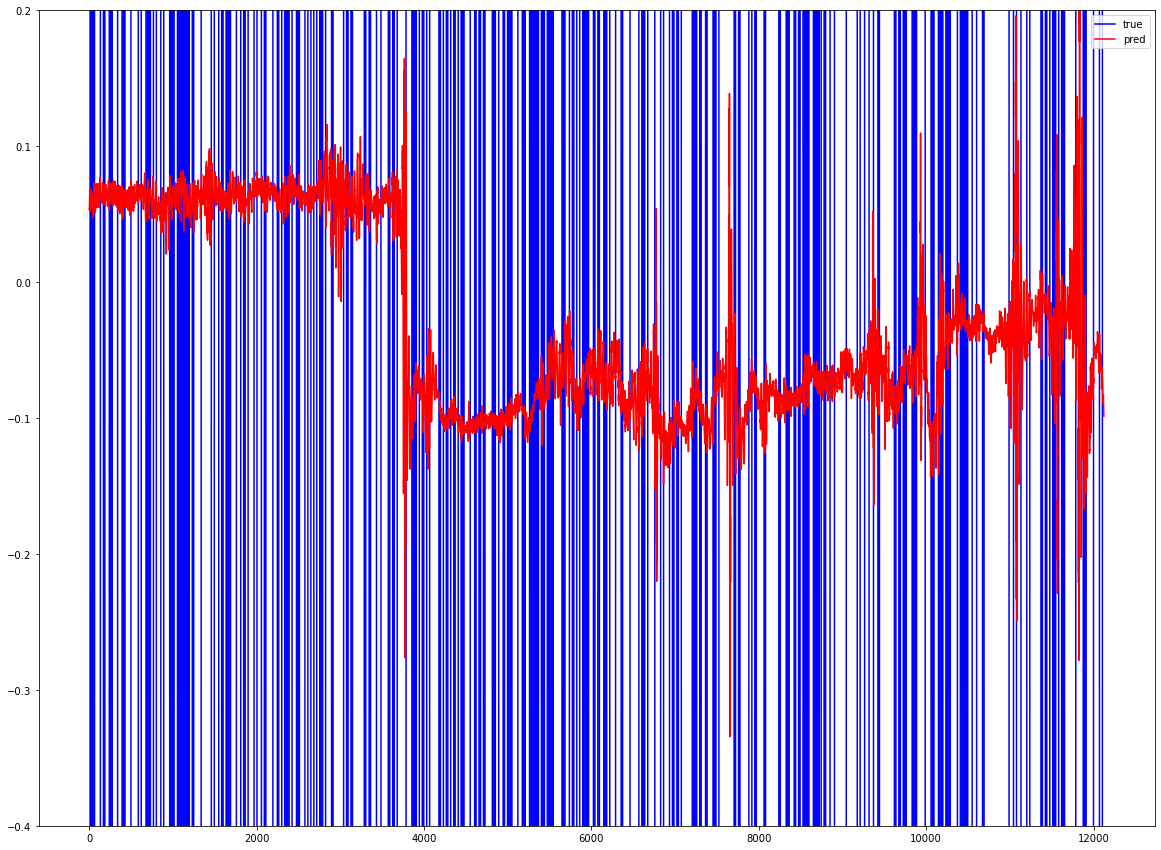

In [ ]:
# LinearRegression
cv=KFold(n_splits=10,random_state=123,shuffle=True)
model = LinearRegression()
scores=cross_val_score(model,X_train,y_train,cv=cv)

y_pred = reg.predict(X_test)

plt.figure(figsize=(20,15))
plt.ylim(-0.4,0.2)
plt.plot(y_test, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

In [ ]:
#y_pred Change to 1 and -1 compared to previous values
pred1=[]
if y_pred[0]>=0:
    pred1.append(1)
else:
    pred1.append(-1)
    
for i in range(len(y_pred)-1):
    if y_pred[i+1]-y_pred[i]>0.000:    ##
        pred1.insert(i+1, 1)
    else:
        pred1.insert(i+1,-1)
pred1=np.array(pred1)

In [ ]:
import collections
counter = collections.Counter(pred1)
counter

Counter({1: 6120, -1: 6003})

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,pred1))

[[3366 3381]
 [2637 2739]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

          -1       0.56      0.50      0.53      6747
           1       0.45      0.51      0.48      5376

    accuracy                           0.50     12123
   macro avg       0.50      0.50      0.50     12123
weighted avg       0.51      0.50      0.51     12123

